<a href="https://colab.research.google.com/github/harshalk612/DATA6100/blob/main/NeuralNetworks/MNIST_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
import jax
import time
from tqdm import tqdm

#Load MNIST Dataset

In [2]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [3]:
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())

batch_size = 128
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.07MB/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



## Train and test sets

In [4]:
# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = np.array(mnist_dataset.train_labels)

N_train = 10000
train_images = train_images[0:N_train,:] #get a subset of the data
train_labels = train_labels[0:N_train]


# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = np.array(mnist_dataset_test.test_labels)


N_test = 10000
test_images = test_images[0:N_test,:] #get a subset of the data
test_labels = test_labels[0:N_test]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Plotting examples of MNIST dataset

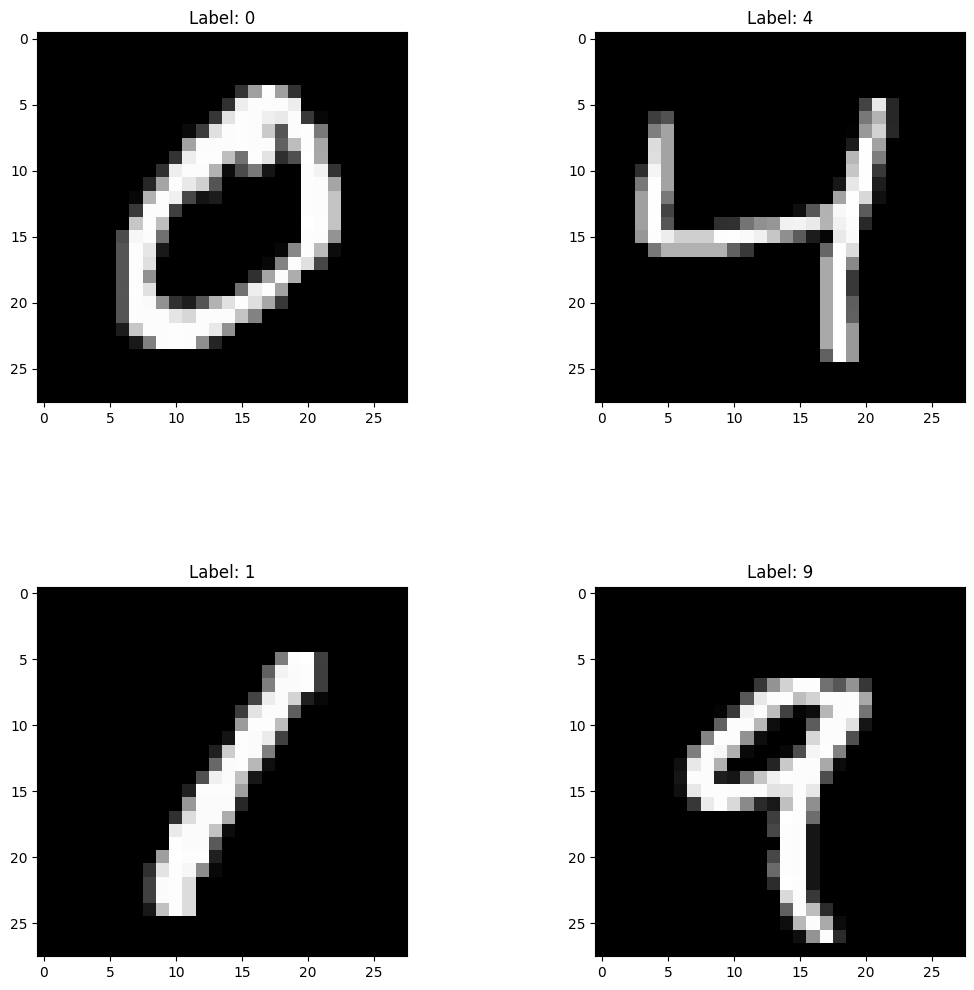

In [7]:
import matplotlib.pyplot as plt

def plot_MNIST_train_examples(my_labels,n_grid = 2):
  figure = plt.figure(figsize=(12, 12))

  #plotting images from the training set
  for i in range(1, n_grid**2 + 1):
    plt.subplot(n_grid, n_grid, i)
    plt.subplots_adjust(hspace =.5, wspace=.5)
    plt.title(f"Label: {my_labels[i]}")

    img = train_images[i].reshape((28,28))
    plt.imshow(img, cmap='gray')

plot_MNIST_train_examples(train_labels)

# Linear Regression (LinR)

We think of linear regression as a [784 by 1] graph.

## Generate random starting paramaters

In [8]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale):
  w_key, b_key = jax.random.split(key)
  return scale * jax.random.normal(w_key, (n, m)), scale * jax.random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key, scale=1e-2):
  keys = jax.random.split(key, len(sizes))
  return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

key = jax.random.PRNGKey(int(time.time()))

In [9]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)

## Create our function and our loss function

In [10]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)

def LinR(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]
  return (jnp.dot(w, x) + b)[0]

print("Lin Reg on 1st training example:")
print(LinR(params,train_images[0]))

Lin Reg on 1st training example:
-39.78414


In [11]:
batched_LinR = jax.vmap(LinR, in_axes=(None, 0))

print("Lin Reg on all training example:")
print(batched_LinR(params,train_images))

Lin Reg on all training example:
[-39.78414  -37.45269  -30.772535 ... -54.241497 -21.048538 -30.67897 ]


In [12]:
def MSE_loss_for_LinR(params,images,target):
  preds = batched_LinR(params, images)
  return jnp.mean( (preds - target)**2 )

print("MSE loss of LinR on training set:")
print(MSE_loss_for_LinR(params,train_images,train_labels))

MSE loss of LinR on training set:
1507.9796


# Training loop using gradient descent

In [13]:
import time

from functools import partial

@partial(jax.jit, static_argnames=['loss_func','step_size'])
def update_params(params, x, y, loss_func, step_size):
  grads = jax.grad(loss_func)(params, x, y)

  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

#trains ``params'' according to the given loss_func
def training_loop(loss_func, acc_func=None, num_epochs = 2, step_size = 0.01):
  global params
  saved_results = []
  for epoch in range(1,num_epochs+1):
      print(f"---Epoch {epoch}---")
      #Update the weights by gradient descent!
      start_time = time.time()
      for x, y in tqdm(training_generator):
          #turn the labels into one hot vectors
          grads = jax.grad(loss_func)(params, x, y)

          params = update_params(params, x, y, loss_func, step_size)

          #params = [(w - step_size * dw, b - step_size * db)
          #          for (w, b), (dw, db) in zip(params, grads)]

      #### A bunch of bookeeping here.... ####
      #Print and record stats of this epoch
      if acc_func != None:
        train_acc = acc_func(params, train_images, train_labels)
        test_acc = acc_func(params, test_images, test_labels)

      train_CE_loss = loss_func(params, train_images, train_labels)
      test_CE_loss = loss_func(params, test_images, test_labels)

      results_dict = {'epoch': epoch,
              'train_loss': np.copy(train_CE_loss).item(),
              'test_loss': np.copy(test_CE_loss).item(),
              }

      if acc_func != None:
        results_dict['train_acc'] = np.copy(train_acc).item()
        results_dict['test_acc'] = np.copy(test_acc).item()

      saved_results += [results_dict]

      epoch_time = time.time() - start_time
      print(f"--- {epoch_time:0.2f} sec---")
      if acc_func != None:
        print(f"  Train  acc: {train_acc:0.4f}")
        print(f"  Test   acc: {test_acc:0.4f}")
      print(f"  Train loss: {train_CE_loss:0.4f}")
      print(f"  Test  loss: {test_CE_loss:0.4f}")


  return saved_results

In [14]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)
training_loop(MSE_loss_for_LinR,num_epochs=2,step_size = 0.00000001)

---Epoch 1---


100%|██████████| 469/469 [00:08<00:00, 53.83it/s]


--- 8.76 sec---
  Train loss: 129.1933
  Test  loss: 127.2387
---Epoch 2---


100%|██████████| 469/469 [00:07<00:00, 58.86it/s]

--- 7.98 sec---
  Train loss: 95.2668
  Test  loss: 93.7409


[{'epoch': 1, 'train_loss': 129.1933135986328, 'test_loss': 127.2387466430664},
 {'epoch': 2, 'train_loss': 95.26683807373047, 'test_loss': 93.74085235595703}]

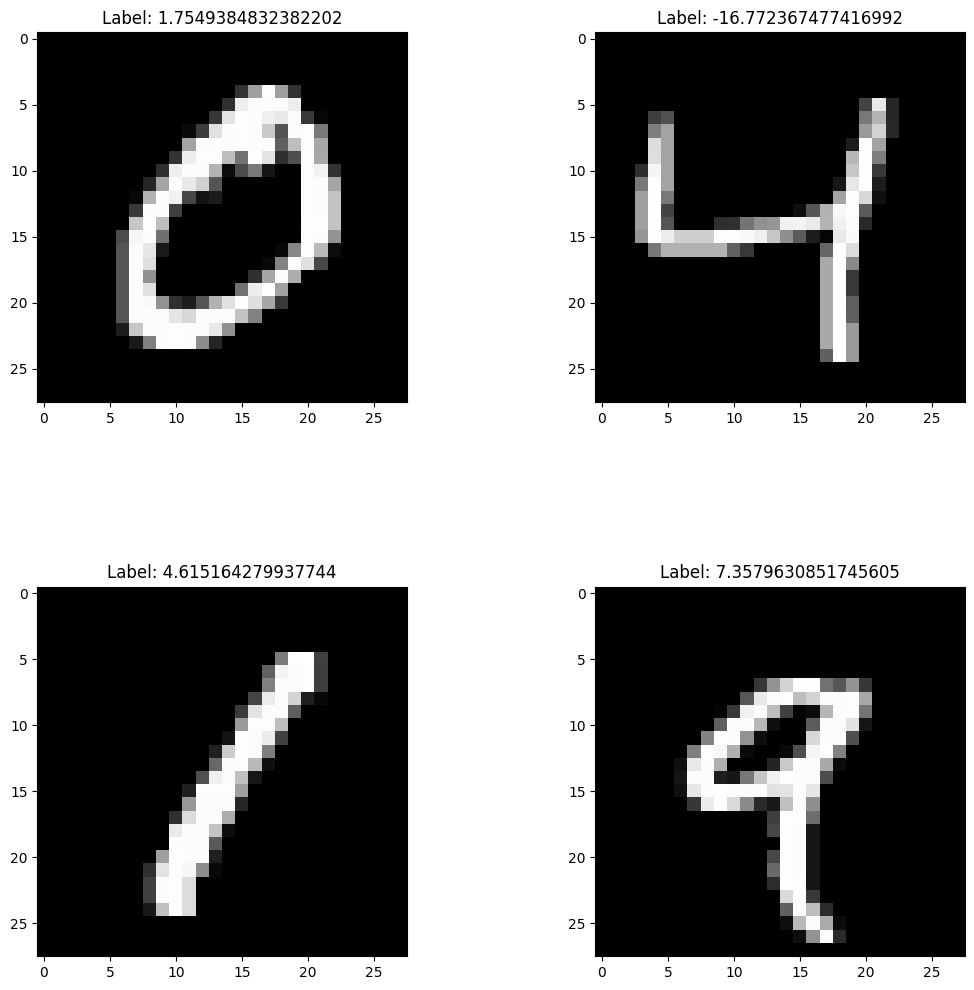

In [15]:
LinR_labels = batched_LinR(params, train_images)
plot_MNIST_train_examples(LinR_labels)

# Non-linear but still regression (NonLinR)

In [16]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key, scale=1e-4)

def sigmoid(x):
  return jnp.exp(x)/(1+jnp.exp(x))

def NonLinR(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]
  return 9*sigmoid( (jnp.dot(w, x) + b) )[0]

print("NonLinR on a single example:")
print(NonLinR(params,train_images[2]))

batched_NonLinR = jax.vmap(NonLinR, in_axes=(None, 0))
print("NonLinR on a all examples:")
print(batched_NonLinR(params,train_images))

def MSE_loss_for_NonLinR(params,images,target):
  preds = batched_NonLinR(params, images)
  return jnp.mean( (preds - target)**2 )

print("MSE of train set for NonLin R")
print(MSE_loss_for_NonLinR(params,train_images,train_labels))

NonLinR on a single example:
3.8130305
NonLinR on a all examples:
[3.6164799 3.6670287 3.8130305 ... 3.3086336 4.028149  3.8150868]
MSE of train set for NonLin R
9.026492


In [17]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)
training_loop(MSE_loss_for_NonLinR,step_size = 0.0000001)

---Epoch 1---


100%|██████████| 469/469 [00:11<00:00, 40.14it/s]


--- 11.71 sec---
  Train loss: 25.7100
  Test  loss: 25.6341
---Epoch 2---


100%|██████████| 469/469 [00:10<00:00, 43.04it/s]

--- 10.92 sec---
  Train loss: 21.8532
  Test  loss: 20.9348


[{'epoch': 1,
  'train_loss': 25.709999084472656,
  'test_loss': 25.634126663208008},
 {'epoch': 2,
  'train_loss': 21.85317039489746,
  'test_loss': 20.934833526611328}]

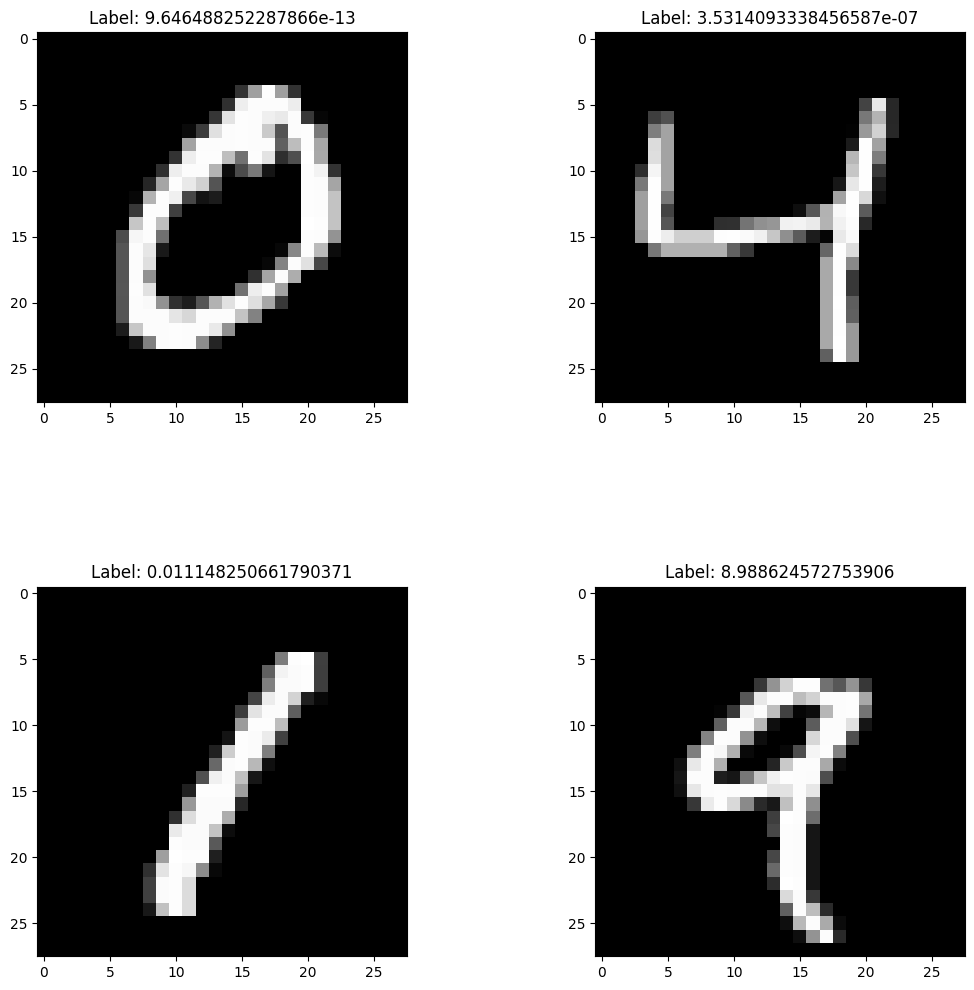

In [18]:
NonLinR_labels = batched_NonLinR(params, train_images)
plot_MNIST_train_examples(NonLinR_labels)

# Logisitic Regression (LogiR)

In [19]:
#Initialize Parameters

layer_sizes = [784, 10]
params = init_network_params(layer_sizes, key)

def sigmoid(x):
  return jnp.exp(x)/(1+jnp.exp(x))

def LogiR_logP(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]
  logits = jnp.dot(w, x) + b
  logits = logits - jnp.max(logits)
  logP = logits - jnp.log(jnp.sum(jnp.exp(logits)))
  return logP

print("LogiR on one example:")
print(LogiR_logP(params, train_images[0]))

batched_LogiR_logP = jax.vmap(LogiR_logP, in_axes=(None, 0))

print("LogiR on all examples:")
print(batched_LogiR_logP(params, train_images))



def CE_loss_for_LogiR(params,images,target):
  preds = batched_LogiR_logP(params, images)
  target_one_hot = jax.nn.one_hot(target, 10)
  return -jnp.mean(preds * target_one_hot)


print("CE loss of LogiR on all example:")
print(CE_loss_for_LogiR(params,train_images,train_labels))

LogiR on one example:
[-19.897907 -33.736965 -59.11621    0.       -34.62549  -20.430828
 -25.678913 -51.88861  -20.312862 -49.439648]
LogiR on all examples:
[[-19.89791    -33.736965   -59.11621    ... -51.88861    -20.312862
  -49.439644  ]
 [ -3.1037645  -35.185238   -20.237022   ... -34.49512    -14.509678
  -21.06223   ]
 [  0.         -53.09841    -73.65452    ... -34.492947   -26.225555
  -46.265778  ]
 ...
 [ -9.66142    -26.368563   -36.990185   ... -34.658424   -12.7683935
  -16.29959   ]
 [-23.995243    -0.09875083 -33.01353    ... -35.35194     -6.429413
   -2.3814313 ]
 [-12.106083   -33.20646    -12.165464   ... -42.56516    -32.13844
   -6.870558  ]]
CE loss of LogiR on all example:
2.7902606


In [20]:
layer_sizes = [784, 10]
params = init_network_params(layer_sizes, key)

def top1_acc_LogiR(params, images, target_class):
  predicted_class = jnp.argmax(batched_LogiR_logP(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

training_loop(CE_loss_for_LogiR,top1_acc_LogiR,num_epochs=5,step_size = 0.01)
print("Done!")

---Epoch 1---


 55%|█████▌    | 259/469 [00:06<00:05, 39.54it/s]


KeyboardInterrupt: 

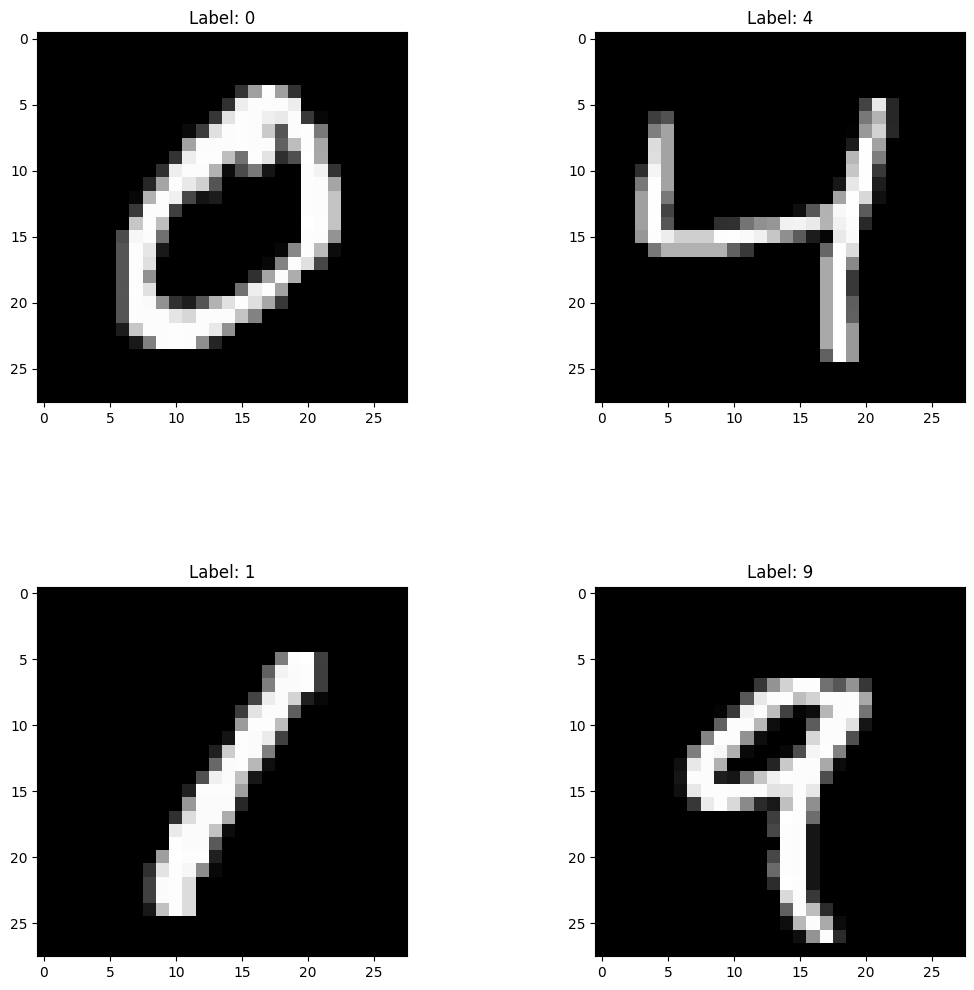

In [21]:
LogiR_labels = batched_LogiR_logP(params, train_images)
plot_MNIST_train_examples(jnp.argmax(LogiR_labels,axis=1))

## Multi-layer perceptron with cross entropy loss (MLP)

In [22]:
layer_sizes = [784, 784, 10]
params = init_network_params(layer_sizes, key)

# rectified linear unit activation function
def relu(x):
  return jnp.maximum(0, x) # compute the element-wise function

def MLP_logP(params, image):
    # per-example predictions
    x = image
    # first layer is feedforward
    w, b = params[0]
    x = (jnp.dot(w, x) + b)
    x_relu = relu(x)

    for w, b in params[1:-1]:
        # skip pre activations
        x = (jnp.dot(w, x_relu) + b)
        x_relu = relu(x)

    final_w, final_b = params[-1]
    logits = (jnp.dot(final_w,  x) + final_b)
    logits = logits - jnp.max(logits)
    return logits - jnp.log(jnp.sum(jnp.exp(logits)))

print("MLP logP on a single examples")
print(MLP_logP(params, train_images[0]))

MLP logP on a single examples
[-1.9394327e+01 -1.7028803e+01 -1.4384272e+01 -2.3244530e+01
 -1.3336799e+01 -1.8449848e+01 -3.7848303e+00 -1.1595614e+01
 -1.4735977e+01 -2.2986732e-02]


In [23]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_MLP_logP = jax.vmap(MLP_logP, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
print("MLP logP on all examples")
batched_preds = batched_MLP_logP(params, train_images)
print(batched_preds)

MLP logP on all examples
[[-1.9394323e+01 -1.7028799e+01 -1.4384272e+01 ... -1.1595607e+01
  -1.4735972e+01 -2.2986965e-02]
 [-4.8685908e+00 -1.0838226e+01 -8.9690666e+00 ... -2.7367941e-01
  -8.1454239e+00 -7.6177649e+00]
 [-7.7128797e+00 -6.8605800e+00 -1.3842971e+01 ... -1.4256772e+01
  -1.5374404e+01 -1.5141901e-02]
 ...
 [-9.3123417e+00 -4.2073958e-02 -8.7878609e+00 ... -8.0848217e+00
  -3.4312270e+00 -4.7934189e+00]
 [-1.1830609e+00 -1.3294137e+01 -4.5945721e+00 ... -5.4280396e+00
  -4.6536139e-01 -4.8301220e+00]
 [-1.1415412e+01 -1.2117221e+01 -9.6650763e+00 ... -3.6223640e+00
  -6.1117392e+00 -1.3258507e+00]]


# Loss function

In [24]:
def CE_loss_for_MLP(params, images, target):
  preds = batched_MLP_logP(params, images)
  target_one_hot = jax.nn.one_hot(target, 10)
  return -jnp.mean(preds * target_one_hot) + 0.01 * sum([jnp.sum(w ** 2) for w,b in params])

print("CE loss for the the MLP")
print(CE_loss_for_MLP(params, train_images, train_labels))


CE loss for the the MLP
1.4120059


In [25]:
layer_sizes = [784, 784, 784, 10]
params = init_network_params(layer_sizes, key)


def top1_acc_MLP(params, images, target_class):
  predicted_class = jnp.argmax(batched_MLP_logP(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

training_loop(CE_loss_for_MLP, top1_acc_MLP, num_epochs=10)

---Epoch 1---


100%|██████████| 469/469 [00:24<00:00, 19.20it/s]


--- 24.57 sec---
  Train  acc: 0.9249
  Test   acc: 0.9253
  Train loss: 1.0536
  Test  loss: 1.0535
---Epoch 2---


100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


--- 21.22 sec---
  Train  acc: 0.9423
  Test   acc: 0.9406
  Train loss: 0.8758
  Test  loss: 0.8761
---Epoch 3---


100%|██████████| 469/469 [00:20<00:00, 22.48it/s]


--- 20.92 sec---
  Train  acc: 0.9502
  Test   acc: 0.9486
  Train loss: 0.7301
  Test  loss: 0.7306
---Epoch 4---


100%|██████████| 469/469 [00:20<00:00, 22.80it/s]


--- 20.63 sec---
  Train  acc: 0.9560
  Test   acc: 0.9539
  Train loss: 0.6101
  Test  loss: 0.6105
---Epoch 5---


100%|██████████| 469/469 [00:21<00:00, 22.25it/s]


--- 21.13 sec---
  Train  acc: 0.9591
  Test   acc: 0.9560
  Train loss: 0.5109
  Test  loss: 0.5113
---Epoch 6---


100%|██████████| 469/469 [00:21<00:00, 22.21it/s]


--- 21.18 sec---
  Train  acc: 0.9621
  Test   acc: 0.9578
  Train loss: 0.4289
  Test  loss: 0.4293
---Epoch 7---


100%|██████████| 469/469 [00:20<00:00, 22.58it/s]


--- 20.83 sec---
  Train  acc: 0.9636
  Test   acc: 0.9594
  Train loss: 0.3610
  Test  loss: 0.3614
---Epoch 8---


100%|██████████| 469/469 [00:21<00:00, 22.18it/s]


--- 21.20 sec---
  Train  acc: 0.9649
  Test   acc: 0.9606
  Train loss: 0.3048
  Test  loss: 0.3052
---Epoch 9---


100%|██████████| 469/469 [00:20<00:00, 22.37it/s]


--- 21.03 sec---
  Train  acc: 0.9662
  Test   acc: 0.9622
  Train loss: 0.2583
  Test  loss: 0.2587
---Epoch 10---


100%|██████████| 469/469 [00:20<00:00, 22.97it/s]

--- 20.47 sec---
  Train  acc: 0.9669
  Test   acc: 0.9630
  Train loss: 0.2198
  Test  loss: 0.2202


[{'epoch': 1,
  'train_loss': 1.0535577535629272,
  'test_loss': 1.0535449981689453,
  'train_acc': 0.9248999953269958,
  'test_acc': 0.9253000020980835},
 {'epoch': 2,
  'train_loss': 0.8757738471031189,
  'test_loss': 0.876085638999939,
  'train_acc': 0.9422999620437622,
  'test_acc': 0.9405999779701233},
 {'epoch': 3,
  'train_loss': 0.7301493287086487,
  'test_loss': 0.7305757403373718,
  'train_acc': 0.9501999616622925,
  'test_acc': 0.9485999941825867},
 {'epoch': 4,
  'train_loss': 0.6100775599479675,
  'test_loss': 0.6105349063873291,
  'train_acc': 0.9559999704360962,
  'test_acc': 0.9538999795913696},
 {'epoch': 5,
  'train_loss': 0.5108900666236877,
  'test_loss': 0.511346161365509,
  'train_acc': 0.9590999484062195,
  'test_acc': 0.9559999704360962},
 {'epoch': 6,
  'train_loss': 0.4288555383682251,
  'test_loss': 0.42930489778518677,
  'train_acc': 0.9620999693870544,
  'test_acc': 0.9577999711036682},
 {'epoch': 7,
  'train_loss': 0.3609865605831146,
  'test_loss': 0.3614

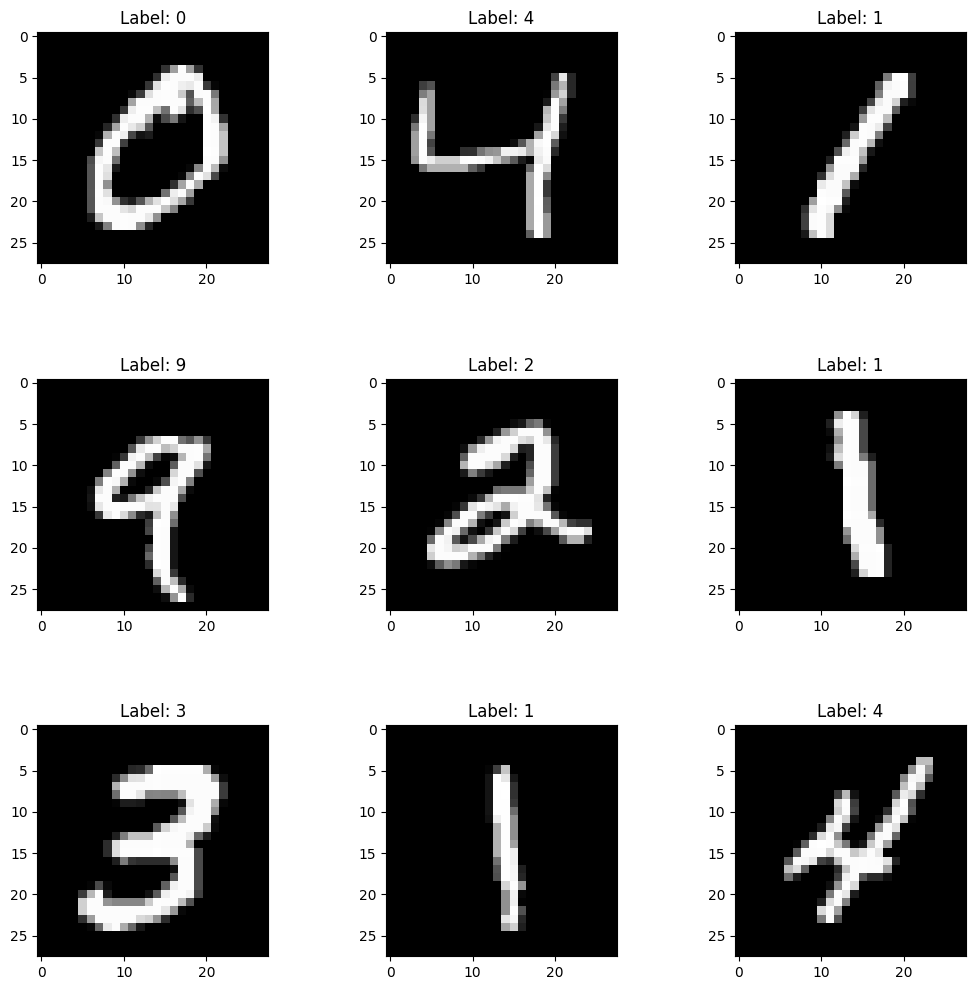

In [26]:
MLP_preds = batched_MLP_logP(params, train_images)
MLP_labels = jnp.argmax(MLP_preds,axis=1)
plot_MNIST_train_examples( MLP_labels,n_grid = 3)

In [27]:
def plot_incorrect_MNIST_train_examples(my_labels,n_grid = 2):
  figure = plt.figure(figsize=(12, 12))

  #plotting images from the training set
  image_ix = 0
  for i in range(1, n_grid**2 + 1):
    image_ix += 1
    plt.subplot(n_grid, n_grid, i)
    plt.subplots_adjust(hspace =.5, wspace=.5)
    while train_labels[image_ix] == my_labels[image_ix]:
      image_ix += 1
    plt.title(f"My Label: {my_labels[image_ix]}, Actual: {train_labels[image_ix]}")
    img = train_images[image_ix].reshape((28,28))
    plt.imshow(img, cmap='gray')

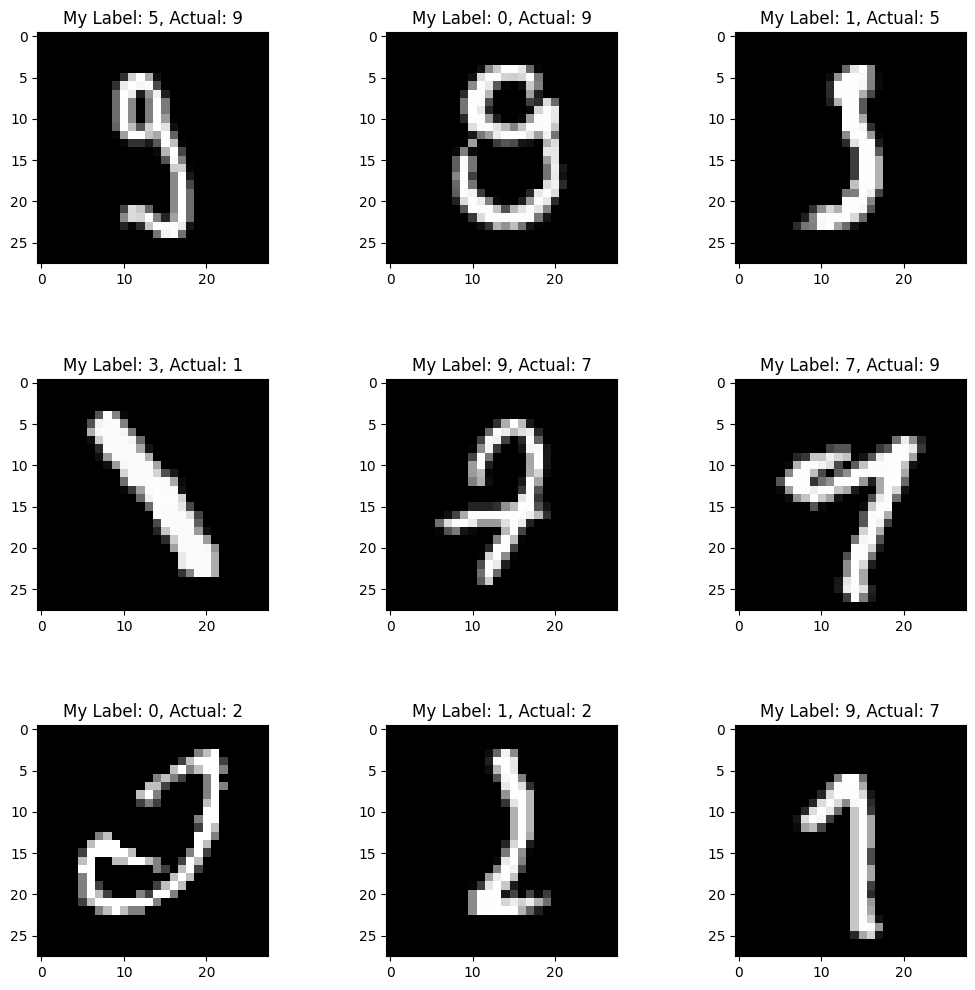

In [28]:
MLP_preds = batched_MLP_logP(params, train_images)
MLP_labels = jnp.argmax(MLP_preds,axis=1)
plot_incorrect_MNIST_train_examples( MLP_labels,n_grid = 3)